<a href="https://colab.research.google.com/github/kaiju8/GANs-Implemented/blob/main/DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt

In [11]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            #Input = Nxchannels_imgx64x64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),

            self._block(features_d, features_d*2, 4, 2, 1), #Nxfeatures_d*2x32x32
            self._block(features_d*2, features_d*4, 4, 2, 1), #Nxfeatures_d*4x16x16
            self._block(features_d*4, features_d*8, 4, 2, 1), #Nxfeatures_d*8x8x8
            self._block(features_d*8, features_d*16, 4, 2, 1), #Nxfeatures_d*16x4x4

            nn.Conv2d(features_d*16, 1, kernel_size=4, stride=2, padding=1), #Nx1x4x4
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = False,),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, x):
        return self.disc(x)

In [12]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            #Input = N*z_dim*1*1
            self._block(z_dim, features_g*16, 4, 1, 0), #N*features_g*16*4*4
            self._block(features_g*16, features_g*8, 4, 2, 1), #N*features_g*8*8*8
            self._block(features_g*8, features_g*4, 4, 2, 1), #N*features_g*4*16*16
            self._block(features_g*4, features_g*2, 4, 2, 1), #N*features_g*2*32*32
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1), #N*channels_img*64*64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.gen(x)

In [13]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m , (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    initialize_weights(gen)
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")

In [14]:
test()

Success, tests passed!


In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
lr = 2e-4 #vary 
z_dim = 100 #vary
img_dim = 64
channels_img = 1
batch_size = 128
num_epochs = 5
features_d = 64
features_g = 64

In [17]:
transforms = transforms.Compose(
    [
        transforms.Resize(img_dim),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(channels_img)],[0.5 for _ in range(channels_img)]),     
    ]
) 

In [18]:
dataset = datasets.MNIST(root = "dataset", transform = transforms, download = True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 70528152.67it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107867937.51it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17071849.02it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17366024.40it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [19]:
disc = Discriminator(channels_img, features_d).to(device)
gen = Generator(z_dim, channels_img, features_g).to(device)

In [20]:
initialize_weights(disc)
initialize_weights(gen)

opt_disc = optim.Adam(disc.parameters(), lr = lr, betas=(0.5,0.999))
opt_gen = optim.Adam(gen.parameters(), lr = lr, betas=(0.5,0.999))

In [21]:
criterion = nn.BCELoss()

In [22]:
fixed_noise = torch.randn((32, z_dim, 1, 1)).to(device)

In [23]:
def show(imgs): #Show function from pytorch.org
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

Epoch [0/5] Batch 0/469 \Loss D: 0.6974, loss G: 0.7752
Epoch [1/5] Batch 0/469 \Loss D: 0.4717, loss G: 1.5392
Epoch [2/5] Batch 0/469 \Loss D: 0.4684, loss G: 2.5371
Epoch [3/5] Batch 0/469 \Loss D: 1.0683, loss G: 3.4913
Epoch [4/5] Batch 0/469 \Loss D: 1.4020, loss G: 1.5067


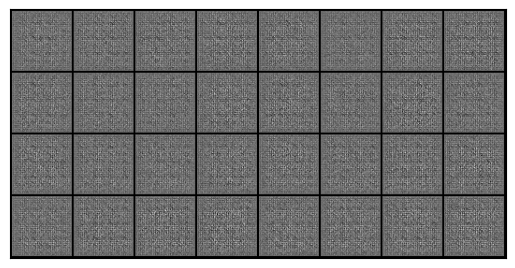

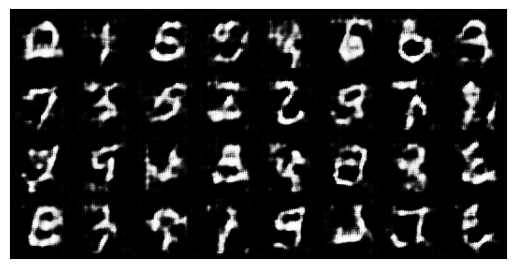

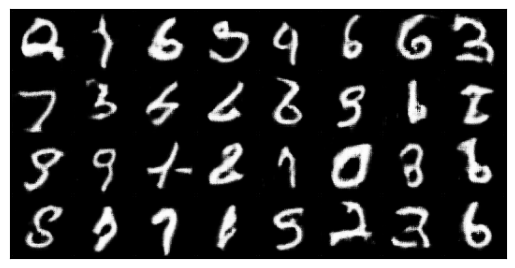

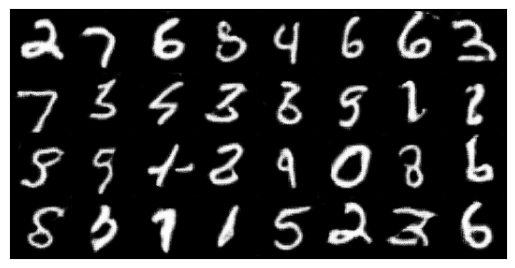

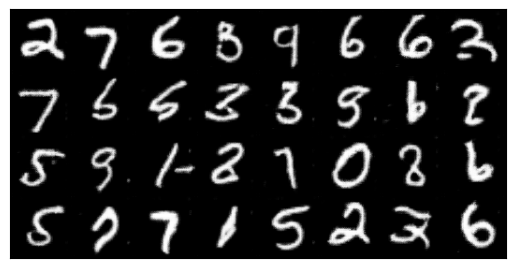

In [24]:
for epoch in range(num_epochs):

  for batch_idx, (real, _) in enumerate(loader):
    real = real.to(device)
    #batch_Size = real.shape[0]

    #Discriminator max log(D(real)) + log(1 - D(G(z)))

    noise = torch.randn((batch_size, z_dim, 1, 1)).to(device)
    fake = gen(noise)

    disc_real = disc(real).reshape(-1)
    loss_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake).reshape(-1)# detach for generator stuff or a
    loss_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    loss_D = (loss_real + loss_fake)/2

    disc.zero_grad()
    loss_D.backward(retain_graph = True)# a
    opt_disc.step()

    #Discriminator min log(1 - D(G(z))) but better to max log(D(G(z)))

    output = disc(fake).reshape(-1)
    loss_G = criterion(output, torch.ones_like(output))

    gen.zero_grad()
    loss_G.backward(retain_graph = True)# a
    opt_gen.step()


###################################################
    if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \Loss D: {loss_D:.4f}, loss G: {loss_G:.4f}")

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 64, 64)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                show(img_grid_fake)
####################################################